#Хакатон First Cup от Data Secret на данных Додо-пиццы

##1. Загрузка и подготовка данных

Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, ElasticNet, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import warnings
warnings.filterwarnings('ignore')

Загрузка данных

In [ ]:
dir = "C:/Users/79504/Desktop/Projects/data_secrets_first_cup/Data Secrets First Cup/"
orders = pd.read_csv(dir + 'orders.csv')
mobile_events = pd.read_csv(dir + 'mobile_events.csv')
clients_promo_october = pd.read_csv(dir + 'clients_promo_october.csv')
train_target = pd.read_csv(dir + 'train_target.csv')
test = pd.read_csv(dir + 'test.csv')


Группируем признаки по клиентам

In [ ]:
orders['Date'] = pd.to_datetime(orders['Date'])
orders['SaleDate'] = pd.to_datetime(orders['SaleDate'])

# Рассчитаем время между заказами и время с последнего заказа
orders = orders.sort_values(by=['ClientUUId', 'Date'])
orders['PrevOrderDate'] = orders.groupby('ClientUUId')['Date'].shift(1)
orders['PrevOrderDate'] = pd.to_datetime(orders['PrevOrderDate'])  # Убедитесь, что это datetime
orders['DaysSinceLastOrder'] = (orders['Date'] - orders['PrevOrderDate']).dt.days.fillna(0)

orders_agg = orders.groupby('ClientUUId').agg({
    'OrderUUId': 'count',
    'OrderTotalPrice': ['sum', 'mean'],
    'apply_promo': 'sum',
    'NewClient': 'max',
    'ProductTotalPrice': 'mean',
    'MenuPrice': 'mean',
    'DaysSinceLastOrder': 'mean'
}).reset_index()

orders_agg.columns = [
    'ClientUUId',
    'num_orders',
    'total_order_price',
    'avg_order_price',
    'num_applied_promos',
    'is_new_client',
    'avg_product_total_price',
    'avg_menu_price',
    'avg_days_since_last_order'
]

orders_agg['discount_per_order'] = orders_agg['avg_menu_price'] - orders_agg['avg_product_total_price']
orders_agg['promo_percentage'] = orders_agg['num_applied_promos'] / orders_agg['num_orders']

orders_agg

,ClientUUId,num_orders,total_order_price,avg_order_price,num_applied_promos,is_new_client,avg_product_total_price,avg_menu_price,avg_days_since_last_order,discount_per_order,promo_percentage
0,000D3A20F23EA95811E7B7104AC23CD3,74,84346.0,1139.810811,62,0,149.743243,201.202703,2.486486,51.459459,0.837838
1,000D3A20F23EA95811E7B88F5E50100B,52,59815.0,1150.288462,6,0,173.557692,193.076923,3.307692,19.519231,0.115385
2,000D3A20F23EA95811E7B8BD71C73877,35,33096.0,945.600000,5,0,245.000000,302.400000,2.400000,57.400000,0.142857
3,000D3A20F23EA95811E7B95FE7E6321C,48,43403.0,904.229167,5,0,174.020833,217.916667,3.479167,43.895833,0.104167
4,000D3A20F23EA95811E7B969B5BD2C3F,34,39798.0,1170.529412,0,0,330.176471,395.558824,2.882353,65.382353,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
16332,FEDF5AD2CE2EA90211ED506C43F7C986,24,12487.0,520.291667,3,0,163.041667,217.625000,8.708333,54.583333,0.125000
16333,FEE22A126ECA916311ECF33D671B594D,67,78230.0,1167.611940,43,0,163.716418,220.761194,2.462687,57.044776,0.641791
16334,FEE611D04A50966311ED36EFD083D176,45,55113.0,1224.733333,0,0,244.511111,293.911111,1.400000,49.400000,0.000000
16335,FEE611D04A50BE1A11ED390682517C35,28,16976.0,606.285714,13,0,201.571429,299.821429,6.285714,98.250000,0.464286


In [ ]:
# 2. Историческое использование промо
clients_promo_october['OrderPrice'] = clients_promo_october['OrderPrice'].fillna(0)
promo_history = clients_promo_october.groupby('ClientUUId').agg({
    'Id': 'count',
    'Discount': 'sum',
    'OrderPrice': 'mean'
}).reset_index()

promo_history.columns = ['ClientUUId', 'num_promos', 'total_discount', 'avg_order_price_promo']

# 3. Интерактивные Признаки
# Влияние использования промо на общий объем заказов
orders_with_promo = orders[orders['apply_promo'] == 1].groupby('ClientUUId').agg({
    'OrderTotalPrice': 'sum'
}).reset_index()
orders_with_promo.columns = ['ClientUUId', 'total_order_price_with_promo']

# Влияние разных типов промо
promo_types = clients_promo_october.groupby(['ClientUUId', 'Id']).agg({
    'Discount': 'sum'
}).reset_index()

promo_types_agg = promo_types.groupby('ClientUUId').agg({
    'Id': 'nunique',
    'Discount': 'sum'
}).reset_index()

promo_types_agg.columns = ['ClientUUId', 'num_unique_promos', 'total_discount_promo']

# 5. Признаки на Основе Платформы
platform_events = mobile_events.groupby('ClientUUId').agg({
    'VisitToken': 'count',
    'EventName': 'nunique',
    'Platform': 'nunique'
}).reset_index()

platform_events.columns = ['ClientUUId', 'num_events', 'num_unique_events', 'num_platforms']

# Объединение данных
train_data = train_target.merge(orders_agg, on='ClientUUId', how='left')
train_data = train_data.merge(promo_history, on='ClientUUId', how='left')
train_data = train_data.merge(orders_with_promo, on='ClientUUId', how='left')
train_data = train_data.merge(promo_types_agg, on='ClientUUId', how='left')
train_data = train_data.merge(platform_events, on='ClientUUId', how='left')

# Очистка данных
train_data = train_data.drop(columns=['ClientUUId', 'OrderType', 'LocalBeginDate', 'LocalEndDate'])
train_data['Id'] = pd.to_numeric(train_data['Id'])

# Объединение данных
train_data = train_target.merge(orders_agg, on='ClientUUId', how='left')
train_data = train_data.merge(promo_history, on='ClientUUId', how='left')
train_data = train_data.merge(orders_with_promo, on='ClientUUId', how='left')
train_data = train_data.merge(promo_types_agg, on='ClientUUId', how='left')
train_data = train_data.merge(platform_events, on='ClientUUId', how='left')

# Очистка данных
train_data = train_data.drop(columns=['ClientUUId', 'OrderType', 'LocalBeginDate', 'LocalEndDate'])
train_data['Id'] = pd.to_numeric(train_data['Id'])
print(train_data.head())

   Id  OrderPrice  Discount  apply_promo  num_orders  total_order_price  \
0   7         699       200            0        33.0            61173.0   
1   6        1249        25            0        33.0            61173.0   
2   5         799       200            0         NaN                NaN   
3   5        1249       250            0         NaN                NaN   
4   6         699        30            0         NaN                NaN   

   avg_order_price  num_applied_promos  is_new_client  \
0      1853.727273                 0.0            0.0   
1      1853.727273                 0.0            0.0   
2              NaN                 NaN            NaN   
3              NaN                 NaN            NaN   
4              NaN                 NaN            NaN   

   avg_product_total_price  ...  promo_percentage  num_promos  total_discount  \
0               278.151515  ...               0.0          14            1125   
1               278.151515  ...             

Аналагоично для тестового датасета

In [ ]:

test_data = test.merge(orders_agg, on='ClientUUId', how='left')
test_data = test_data.merge(promo_history, on='ClientUUId', how='left')
test_data = test_data.merge(orders_with_promo, on='ClientUUId', how='left')
test_data = test_data.merge(promo_types_agg, on='ClientUUId', how='left')
test_data = test_data.merge(platform_events, on='ClientUUId', how='left')

test_data = test_data.drop(columns=['ClientUUId', 'OrderType', 'LocalBeginDate', 'LocalEndDate'])
test_data['Id'] = pd.to_numeric(test_data['Id'])
#test_data = test_data.fillna(0)


In [ ]:
train_data

,Id,OrderPrice,Discount,apply_promo,num_orders,total_order_price,avg_order_price,num_applied_promos,is_new_client,avg_product_total_price,...,promo_percentage,num_promos,total_discount,avg_order_price_promo,total_order_price_with_promo,num_unique_promos,total_discount_promo,num_events,num_unique_events,num_platforms
0,7,699,200,0,33.0,61173.0,1853.727273,0.0,0.0,278.151515,...,0.000000,14,1125,1002.571429,NaN,3,1125,187.0,8.0,1.0
1,6,1249,25,0,33.0,61173.0,1853.727273,0.0,0.0,278.151515,...,0.000000,14,1125,1002.571429,NaN,3,1125,187.0,8.0,1.0
2,5,799,200,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,12,1135,982.333333,NaN,3,1135,97.0,8.0,1.0
3,5,1249,250,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,12,1135,982.333333,NaN,3,1135,97.0,8.0,1.0
4,6,699,30,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,18,2410,985.111111,NaN,3,2410,103.0,9.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27736,5,799,200,0,42.0,60631.0,1443.595238,10.0,0.0,315.904762,...,0.238095,18,2115,1054.555556,19108.0,3,2115,159.0,11.0,1.0
27737,5,1249,250,0,42.0,60631.0,1443.595238,10.0,0.0,315.904762,...,0.238095,18,2115,1054.555556,19108.0,3,2115,159.0,11.0,1.0
27738,6,799,20,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,16,1370,995.875000,NaN,3,1370,121.0,9.0,1.0
27739,5,749,200,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,18,2330,1001.777778,NaN,3,2330,127.0,8.0,1.0


Проверим на пропущенные значения

In [ ]:
train_data.isna().sum()


Id                                  0
OrderPrice                          0
Discount                            0
apply_promo                         0
num_orders                      12721
total_order_price               12721
avg_order_price                 12721
num_applied_promos              12721
is_new_client                   12721
avg_product_total_price         12721
avg_menu_price                  12721
avg_days_since_last_order       12721
discount_per_order              12721
promo_percentage                12721
num_promos                          0
total_discount                      0
avg_order_price_promo               0
total_order_price_with_promo    19339
num_unique_promos                   0
total_discount_promo                0
num_events                        161
num_unique_events                 161
num_platforms                     161
dtype: int64

In [ ]:
test_data.isna().sum()

Id                                 0
OrderPrice                         0
Discount                           0
num_orders                      3087
total_order_price               3087
avg_order_price                 3087
num_applied_promos              3087
is_new_client                   3087
avg_product_total_price         3087
avg_menu_price                  3087
avg_days_since_last_order       3087
discount_per_order              3087
promo_percentage                3087
num_promos                         0
total_discount                     0
avg_order_price_promo              0
total_order_price_with_promo    4741
num_unique_promos                  0
total_discount_promo               0
num_events                        34
num_unique_events                 34
num_platforms                     34
dtype: int64

Заполним пропуски 0, где значение может равняться нулю (к примеру число заказов) и медианой, где имеет это имеет смысл.

In [ ]:
# Признаки, где 0 имеет смысл
numerical_features = [
    'num_orders',
    'total_order_price',
    'avg_order_price',
    'num_applied_promos',
    'avg_product_total_price',
    'avg_menu_price',
    'num_events',
    'num_unique_events',
    'num_platforms',
    'num_promos',
    'total_discount',
    'avg_order_price_promo',
]

# Замена NaN на 0 для числовых признаков
train_data[numerical_features] = train_data[numerical_features].fillna(0)
test_data[numerical_features] = test_data[numerical_features].fillna(0)

# Замена NaN на медиану для средних значений
median_features = [
    'avg_order_price',
    'avg_product_total_price',
    'avg_menu_price',
    'discount_per_order',
    'promo_percentage',
    'avg_order_price_promo',
    'avg_days_since_last_order'
]

for feature in median_features:
    median_value = train_data[feature].median()
    train_data[feature].fillna(median_value, inplace=True)

for feature in median_features:
    median_value = test_data[feature].median()
    test_data[feature].fillna(median_value, inplace=True)


# Замена NaN для total_order_price_with_promo
train_data['total_order_price_with_promo'].fillna(0, inplace=True)
test_data['total_order_price_with_promo'].fillna(0, inplace=True)


# Замена NaN для is_new_client
train_data['is_new_client'].fillna(1, inplace=True)
test_data['is_new_client'].fillna(1, inplace=True)

print("NaN values have been filled.")


NaN values have been filled.


In [ ]:
train_data.isna().sum()

Id                              0
OrderPrice                      0
Discount                        0
apply_promo                     0
num_orders                      0
total_order_price               0
avg_order_price                 0
num_applied_promos              0
is_new_client                   0
avg_product_total_price         0
avg_menu_price                  0
avg_days_since_last_order       0
discount_per_order              0
promo_percentage                0
num_promos                      0
total_discount                  0
avg_order_price_promo           0
total_order_price_with_promo    0
num_unique_promos               0
total_discount_promo            0
num_events                      0
num_unique_events               0
num_platforms                   0
dtype: int64

In [ ]:
test_data.isna().sum()

Id                              0
OrderPrice                      0
Discount                        0
num_orders                      0
total_order_price               0
avg_order_price                 0
num_applied_promos              0
is_new_client                   0
avg_product_total_price         0
avg_menu_price                  0
avg_days_since_last_order       0
discount_per_order              0
promo_percentage                0
num_promos                      0
total_discount                  0
avg_order_price_promo           0
total_order_price_with_promo    0
num_unique_promos               0
total_discount_promo            0
num_events                      0
num_unique_events               0
num_platforms                   0
dtype: int64

In [ ]:
train_data.describe()

,Id,OrderPrice,Discount,apply_promo,num_orders,total_order_price,avg_order_price,num_applied_promos,is_new_client,avg_product_total_price,...,promo_percentage,num_promos,total_discount,avg_order_price_promo,total_order_price_with_promo,num_unique_promos,total_discount_promo,num_events,num_unique_events,num_platforms
count,27741.000000,27741.000000,27741.000000,27741.000000,27741.000000,2.774100e+04,27741.000000,27741.000000,27741.000000,27741.000000,...,27741.000000,27741.000000,27741.000000,27741.000000,27741.000000,27741.000000,27741.000000,27741.000000,27741.000000,27741.000000
mean,6.089831,943.219747,162.694928,0.029811,20.565445,2.463526e+04,560.954315,3.928806,0.462456,139.707411,...,0.140397,15.902058,1908.222667,997.666992,4720.148517,2.735265,1908.222667,130.458455,9.406294,1.003677
std,0.861960,225.759604,86.335719,0.170070,22.936586,1.894725e+05,984.868884,8.829312,0.498597,154.584802,...,0.169384,2.823560,715.696512,80.145800,13345.781428,0.479417,715.696512,92.630572,1.296711,0.123577
min,5.000000,599.000000,15.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.000000,30.000000,699.000000,0.000000,1.000000,30.000000,0.000000,0.000000,0.000000
25%,5.000000,799.000000,100.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.063830,14.000000,1425.000000,961.500000,0.000000,3.000000,1425.000000,72.000000,9.000000,1.000000
50%,6.000000,799.000000,200.000000,0.000000,18.000000,1.098100e+04,542.360000,0.000000,0.000000,135.800000,...,0.093750,16.000000,1905.000000,1010.111111,0.000000,3.000000,1905.000000,108.000000,9.000000,1.000000
75%,7.000000,1249.000000,200.000000,0.000000,36.000000,3.446800e+04,978.454545,4.000000,1.000000,240.591837,...,0.117647,18.000000,2390.000000,1034.714286,3599.000000,3.000000,2390.000000,161.000000,10.000000,1.000000
max,7.000000,1249.000000,300.000000,1.000000,244.000000,2.188788e+07,89704.430328,169.000000,1.000000,1038.482759,...,1.000000,18.000000,4670.000000,1349.000000,486791.000000,3.000000,4670.000000,2257.000000,11.000000,2.000000


In [ ]:
train_data.columns

Index(['Id', 'OrderPrice', 'Discount', 'apply_promo', 'num_orders',
       'total_order_price', 'avg_order_price', 'num_applied_promos',
       'is_new_client', 'avg_product_total_price', 'avg_menu_price',
       'avg_days_since_last_order', 'discount_per_order', 'promo_percentage',
       'num_promos', 'total_discount', 'avg_order_price_promo',
       'total_order_price_with_promo', 'num_unique_promos',
       'total_discount_promo', 'num_events', 'num_unique_events',
       'num_platforms'],
      dtype='object')

In [ ]:
test_data.columns

Index(['Id', 'OrderPrice', 'Discount', 'num_orders', 'total_order_price',
       'avg_order_price', 'num_applied_promos', 'is_new_client',
       'avg_product_total_price', 'avg_menu_price',
       'avg_days_since_last_order', 'discount_per_order', 'promo_percentage',
       'num_promos', 'total_discount', 'avg_order_price_promo',
       'total_order_price_with_promo', 'num_unique_promos',
       'total_discount_promo', 'num_events', 'num_unique_events',
       'num_platforms'],
      dtype='object')

In [ ]:
test_data.describe()

,Id,OrderPrice,Discount,num_orders,total_order_price,avg_order_price,num_applied_promos,is_new_client,avg_product_total_price,avg_menu_price,...,promo_percentage,num_promos,total_discount,avg_order_price_promo,total_order_price_with_promo,num_unique_promos,total_discount_promo,num_events,num_unique_events,num_platforms
count,6806.000000,6806.000000,6806.000000,6806.000000,6806.000000,6806.000000,6806.000000,6806.000000,6806.000000,6806.000000,...,6806.000000,6806.000000,6806.000000,6806.000000,6806.000000,6806.000000,6806.000000,6806.000000,6806.000000,6806.000000
mean,6.113135,943.997061,162.062886,20.856009,23592.430209,565.846308,4.034969,0.456509,141.162056,171.656153,...,0.141019,15.921099,1900.249780,997.490832,4915.509697,2.725096,1900.249780,130.344696,9.395974,1.004996
std,0.855366,225.962599,87.227680,22.752293,38351.383954,639.991429,8.952201,0.498142,155.335691,186.649641,...,0.171654,2.844917,711.166408,76.679714,13665.242546,0.492210,711.166408,90.890663,1.273932,0.122328
min,5.000000,599.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.000000,30.000000,699.000000,0.000000,1.000000,30.000000,0.000000,0.000000,0.000000
25%,5.000000,799.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.055952,14.000000,1425.000000,963.620536,0.000000,2.000000,1425.000000,73.000000,9.000000,1.000000
50%,6.000000,799.000000,200.000000,18.000000,11695.000000,558.065476,0.000000,0.000000,138.446429,167.632653,...,0.093023,16.000000,1910.000000,1008.375000,0.000000,3.000000,1910.000000,107.000000,9.000000,1.000000
75%,7.000000,1249.000000,200.000000,37.000000,36340.000000,991.252195,4.000000,1.000000,240.250000,292.039502,...,0.121212,18.000000,2385.000000,1034.714286,3783.000000,3.000000,2385.000000,160.000000,10.000000,1.000000
max,7.000000,1249.000000,300.000000,169.000000,759012.000000,10690.309859,116.000000,1.000000,1111.285714,1111.285714,...,1.000000,18.000000,4450.000000,1299.000000,268190.000000,3.000000,4450.000000,1169.000000,11.000000,2.000000


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6806 entries, 0 to 6805
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id                            6806 non-null   int64  
 1   OrderPrice                    6806 non-null   int64  
 2   Discount                      6806 non-null   int64  
 3   num_orders                    6806 non-null   float64
 4   total_order_price             6806 non-null   float64
 5   avg_order_price               6806 non-null   float64
 6   num_applied_promos            6806 non-null   float64
 7   is_new_client                 6806 non-null   float64
 8   avg_product_total_price       6806 non-null   float64
 9   avg_menu_price                6806 non-null   float64
 10  avg_days_since_last_order     6806 non-null   float64
 11  discount_per_order            6806 non-null   float64
 12  promo_percentage              6806 non-null   float64
 13  num

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27741 entries, 0 to 27740
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id                            27741 non-null  int64  
 1   OrderPrice                    27741 non-null  int64  
 2   Discount                      27741 non-null  int64  
 3   apply_promo                   27741 non-null  int64  
 4   num_orders                    27741 non-null  float64
 5   total_order_price             27741 non-null  float64
 6   avg_order_price               27741 non-null  float64
 7   num_applied_promos            27741 non-null  float64
 8   is_new_client                 27741 non-null  float64
 9   avg_product_total_price       27741 non-null  float64
 10  avg_menu_price                27741 non-null  float64
 11  avg_days_since_last_order     27741 non-null  float64
 12  discount_per_order            27741 non-null  float64
 13  p

Проверим на наличие дубликатов

In [ ]:
print(train_data[train_data.duplicated()])

Empty DataFrame
Columns: [Id, OrderPrice, Discount, apply_promo, num_orders, total_order_price, avg_order_price, num_applied_promos, is_new_client, avg_product_total_price, avg_menu_price, avg_days_since_last_order, discount_per_order, promo_percentage, num_promos, total_discount, avg_order_price_promo, total_order_price_with_promo, num_unique_promos, total_discount_promo, num_events, num_unique_events, num_platforms]
Index: []

[0 rows x 23 columns]


In [ ]:
print(test_data[test_data.duplicated()])

Empty DataFrame
Columns: [Id, OrderPrice, Discount, num_orders, total_order_price, avg_order_price, num_applied_promos, is_new_client, avg_product_total_price, avg_menu_price, avg_days_since_last_order, discount_per_order, promo_percentage, num_promos, total_discount, avg_order_price_promo, total_order_price_with_promo, num_unique_promos, total_discount_promo, num_events, num_unique_events, num_platforms]
Index: []

[0 rows x 22 columns]


##EDA

Проверим признаки на мультиколлинеарность

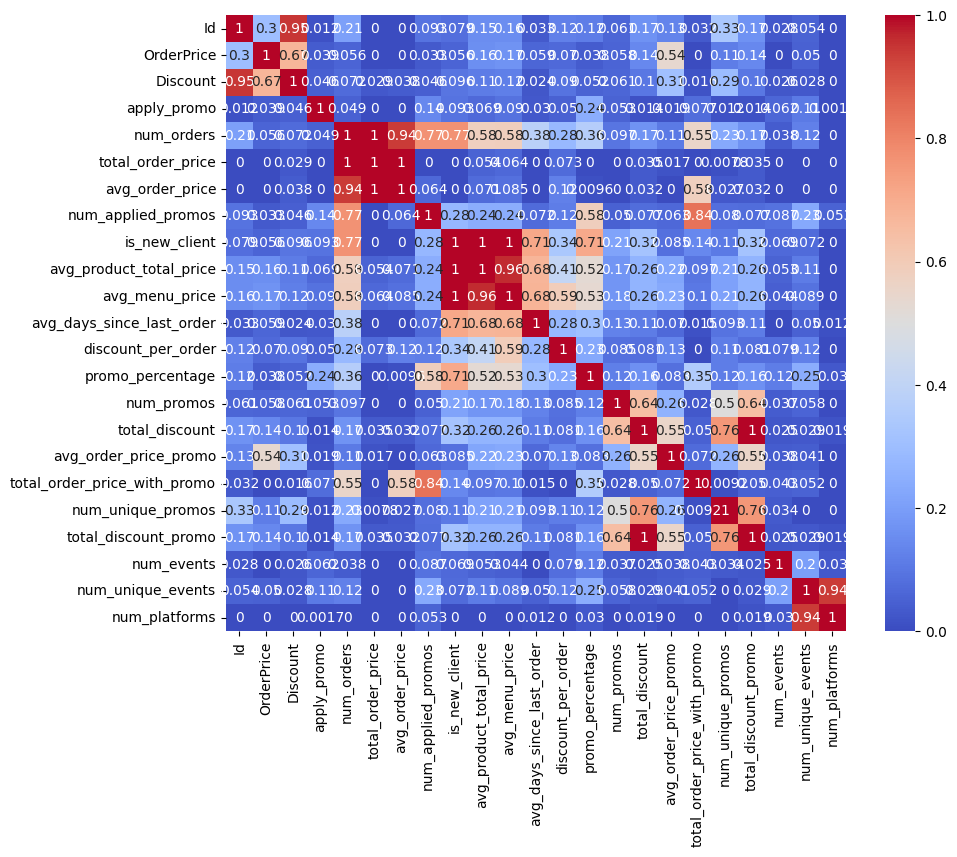

In [ ]:
k = train_data[['Id', 'OrderPrice', 'Discount', 'apply_promo', 'num_orders',
       'total_order_price', 'avg_order_price', 'num_applied_promos',
       'is_new_client', 'avg_product_total_price', 'avg_menu_price',
       'avg_days_since_last_order', 'discount_per_order', 'promo_percentage',
       'num_promos', 'total_discount', 'avg_order_price_promo',
       'total_order_price_with_promo', 'num_unique_promos',
       'total_discount_promo', 'num_events', 'num_unique_events',
       'num_platforms']].phik_matrix(interval_cols=['Id', 'OrderPrice', 'Discount', 'apply_promo', 'num_orders',
       'total_order_price', 'avg_order_price', 'num_applied_promos',
       'is_new_client', 'avg_product_total_price', 'avg_menu_price',
       'avg_days_since_last_order', 'discount_per_order', 'promo_percentage',
       'num_promos', 'total_discount', 'avg_order_price_promo',
       'total_order_price_with_promo', 'num_unique_promos',
       'total_discount_promo', 'num_events', 'num_unique_events',
       'num_platforms'])

plt.figure(figsize=(10, 8))

sns.heatmap(k, annot=True, cmap='coolwarm')

plt.show()

Уберём признаки с высокой корреляцией друг с другом

Columns dropped: ['Discount', 'total_order_price', 'avg_order_price', 'avg_product_total_price', 'avg_menu_price', 'total_discount_promo', 'num_platforms']
Train data shape after dropping columns: (27741, 16)
Test data shape after dropping columns: (6806, 15)


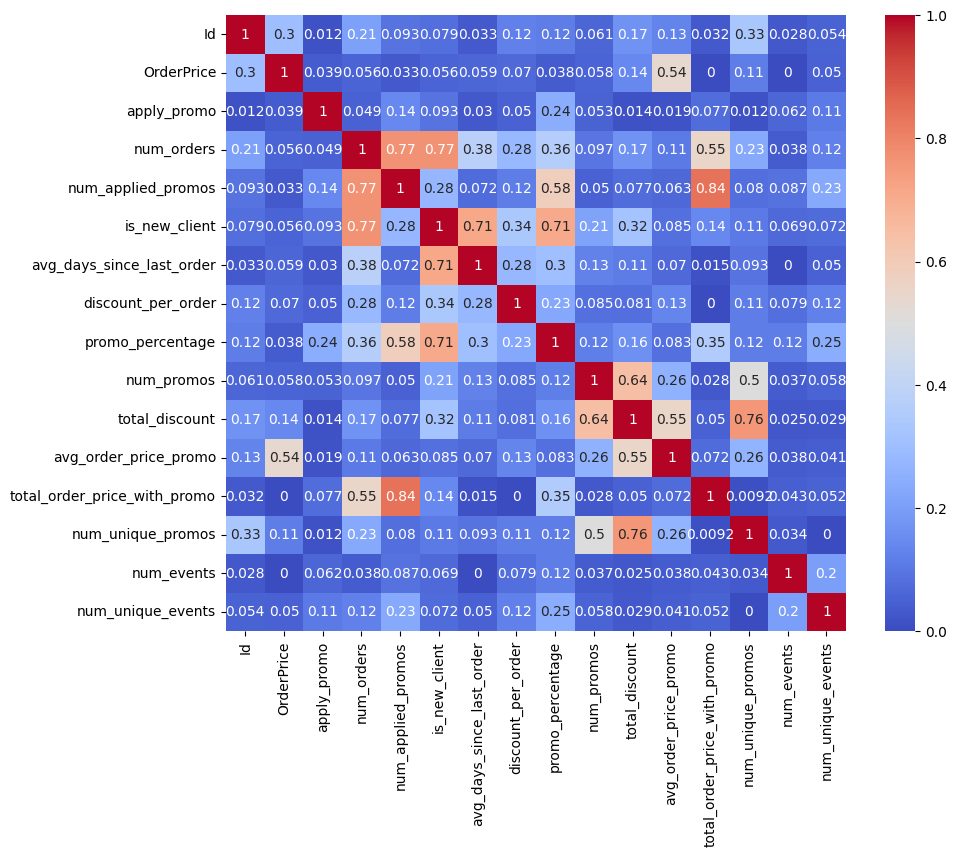

In [ ]:
def get_high_correlation_columns(df, threshold=0.93):
    # Рассчитываем PhiK матрицу
    corr_matrix = df.phik_matrix(interval_cols=df.columns).abs()

    # Создаем маску для верхней треугольной матрицы
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Определяем столбцы, которые нужно удалить
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    return to_drop

# Определяем столбцы для удаления из train_data
columns_to_drop = get_high_correlation_columns(train_data, threshold=0.93)

# Проверяем существование столбцов в датафреймах
existing_columns_to_drop = [col for col in columns_to_drop if col in train_data.columns]

# Удаляем столбцы с высокой корреляцией из обоих датафреймов
train_data_reduced = train_data.drop(columns=existing_columns_to_drop, errors='ignore')
test_data_reduced = test_data.drop(columns=existing_columns_to_drop, errors='ignore')

# Проверяем результат
print("Columns dropped:", existing_columns_to_drop)
print("Train data shape after dropping columns:", train_data_reduced.shape)
print("Test data shape after dropping columns:", test_data_reduced.shape)

# Опционально: визуализируем обновленную матрицу корреляций
plt.figure(figsize=(10, 8))
sns.heatmap(train_data_reduced.phik_matrix(interval_cols=train_data_reduced.columns).abs(), annot=True, cmap='coolwarm')
plt.show()

In [ ]:
train_data.columns

Index(['Id', 'OrderPrice', 'Discount', 'apply_promo', 'num_orders',
       'total_order_price', 'avg_order_price', 'num_applied_promos',
       'is_new_client', 'avg_product_total_price', 'avg_menu_price',
       'avg_days_since_last_order', 'discount_per_order', 'promo_percentage',
       'num_promos', 'total_discount', 'avg_order_price_promo',
       'total_order_price_with_promo', 'num_unique_promos',
       'total_discount_promo', 'num_events', 'num_unique_events',
       'num_platforms'],
      dtype='object')

Построим pariplot

In [ ]:
train_data_count_var = train_data[['OrderPrice', 'Discount',
       'num_orders', 'total_order_price', 'avg_order_price',
       'num_applied_promos', 'avg_product_total_price',
       'avg_menu_price', 'discount_per_order', 'promo_percentage',
       'num_events', 'num_unique_events', 'num_platforms', 'num_promos',
       'total_discount', 'avg_order_price_promo']]

sns.pairplot(train_data_count_var)

##Построение моделей

###Подготовка данных для моделей

Определим тренировочную и тестовую выборку

In [ ]:
X_train = train_data[['Id', 'OrderPrice', 'Discount', 'num_orders',
       'total_order_price', 'avg_order_price', 'num_applied_promos',
       'is_new_client', 'avg_product_total_price', 'avg_menu_price',
       'avg_days_since_last_order', 'discount_per_order', 'promo_percentage',
       'num_promos', 'total_discount', 'avg_order_price_promo',
       'total_order_price_with_promo', 'num_unique_promos',
       'total_discount_promo', 'num_events', 'num_unique_events',
       'num_platforms']]
y_train = train_data['apply_promo']

X_test = test_data[['Id', 'OrderPrice', 'Discount', 'num_orders',
       'total_order_price', 'avg_order_price', 'num_applied_promos',
       'is_new_client', 'avg_product_total_price', 'avg_menu_price',
       'avg_days_since_last_order', 'discount_per_order', 'promo_percentage',
       'num_promos', 'total_discount', 'avg_order_price_promo',
       'total_order_price_with_promo', 'num_unique_promos',
       'total_discount_promo', 'num_events', 'num_unique_events',
       'num_platforms']]

print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape)

Train: (27741, 22) (27741,)
Test: (6806, 22)


Посмотрим на дисбаланс классов

In [ ]:
train_data['apply_promo'].value_counts(normalize=True)

apply_promo
0    0.970189
1    0.029811
Name: proportion, dtype: float64

Посмотрим на категориальные признаки

In [ ]:
for column in X_train.columns:
    # Получаем уникальные значения столбца
    unique_values = X_train[column].unique()

    # Если уникальных значений меньше 8, выводим их
    if len(unique_values) < 8:
        print(f"Уникальные значения в столбце '{column}': {unique_values}")

Уникальные значения в столбце 'Id': [7 6 5]
Уникальные значения в столбце 'is_new_client': [0. 1.]
Уникальные значения в столбце 'num_unique_promos': [3 2 1]
Уникальные значения в столбце 'num_platforms': [1. 0. 2.]


Закодируем их с помощью One Hot Encoder, т.к. это не порядковые переменные

In [ ]:
X_train = pd.get_dummies(X_train, columns=['Id', 'is_new_client', 'num_unique_promos', 'num_platforms'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['Id', 'is_new_client', 'num_unique_promos', 'num_platforms'], drop_first=True)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

Используем оверсэмплинг методом SMOTE для борьбы с дисбалансом

In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN

In [ ]:
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [ ]:
print(f'Размерность тренировочной выборки после сэмплирования: {X_train.shape}')
print(f'Баланс классов после сэмплирования:\n{y_train.value_counts()}')

Размерность тренировочной выборки после сэмплирования: (53828, 25)
Баланс классов после сэмплирования:
apply_promo
0    26914
1    26914
Name: count, dtype: int64


In [ ]:
X_train

,OrderPrice,Discount,num_orders,total_order_price,avg_order_price,num_applied_promos,avg_product_total_price,avg_menu_price,avg_days_since_last_order,discount_per_order,...,total_discount_promo,num_events,num_unique_events,Id_6,Id_7,is_new_client_1.0,num_unique_promos_2,num_unique_promos_3,num_platforms_1.0,num_platforms_2.0
0,699,200,33.00000,61173.000000,1853.727273,0.000000,278.151515,369.696970,2.000000,91.545455,...,1125,187.000000,8.000000,False,True,False,False,True,True,False
1,1249,25,33.00000,61173.000000,1853.727273,0.000000,278.151515,369.696970,2.000000,91.545455,...,1125,187.000000,8.000000,True,False,False,False,True,True,False
2,799,200,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,3.747340,45.621545,...,1135,97.000000,8.000000,False,False,True,False,True,True,False
3,1249,250,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,3.747340,45.621545,...,1135,97.000000,8.000000,False,False,True,False,True,True,False
4,699,30,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,3.747340,45.621545,...,2410,103.000000,9.000000,True,False,True,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53823,646,82,23.00000,15867.832441,689.905758,2.477518,290.773455,353.434022,6.607681,62.660568,...,1475,84.321013,10.522482,True,False,False,False,True,True,False
53824,1133,27,7.00000,7642.000000,1091.714286,0.000000,550.857143,596.285714,29.285714,45.428571,...,1060,169.000000,9.000000,True,True,False,True,False,True,False
53825,799,200,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,3.747340,45.621545,...,1497,100.457490,11.000000,False,False,True,False,True,True,False
53826,1249,72,58.34209,69533.164759,1217.331373,18.506568,225.693060,284.853573,1.514212,59.160513,...,2578,187.621645,10.708881,True,True,False,False,True,True,False


In [ ]:
for column in X_train.columns:
    # Получаем уникальные значения столбца
    unique_values = X_train[column].unique()

    # Если уникальных значений меньше 8, выводим их
    if len(unique_values) < 8:
        print(f"Уникальные значения в столбце '{column}': {unique_values}")


Уникальные значения в столбце 'Id_6': [False  True]
Уникальные значения в столбце 'Id_7': [ True False]
Уникальные значения в столбце 'is_new_client_1.0': [False  True]
Уникальные значения в столбце 'num_unique_promos_2': [False  True]
Уникальные значения в столбце 'num_unique_promos_3': [ True False]
Уникальные значения в столбце 'num_platforms_1.0': [ True False]
Уникальные значения в столбце 'num_platforms_2.0': [False  True]


In [ ]:
X_train.columns

Index(['OrderPrice', 'Discount', 'num_orders', 'total_order_price',
       'avg_order_price', 'num_applied_promos', 'avg_product_total_price',
       'avg_menu_price', 'avg_days_since_last_order', 'discount_per_order',
       'promo_percentage', 'num_promos', 'total_discount',
       'avg_order_price_promo', 'total_order_price_with_promo',
       'total_discount_promo', 'num_events', 'num_unique_events', 'Id_6',
       'Id_7', 'is_new_client_1.0', 'num_unique_promos_2',
       'num_unique_promos_3', 'num_platforms_1.0', 'num_platforms_2.0'],
      dtype='object')

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train.shape

(53828, 25)

###Базовая модель линейной регрессии

In [ ]:
log_reg = LogisticRegression(random_state=42)

log_reg.fit(X_train, y_train)

y_pred_train = log_reg.predict(X_train)
y_pred = log_reg.predict(X_test)
print(f'Метрики train\n{metrics.classification_report(y_train, y_pred_train)}')

Метрики train
              precision    recall  f1-score   support

           0       0.77      0.87      0.82     26914
           1       0.85      0.74      0.79     26914

    accuracy                           0.81     53828
   macro avg       0.81      0.81      0.80     53828
weighted avg       0.81      0.81      0.80     53828



In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

In [ ]:
y_proba_train = log_reg.predict_proba(X_train)[:, 1]
roc_auc = roc_auc_score(y_train, y_proba_train)
print(f'ROC AUC: {roc_auc:.2f}')

ROC AUC: 0.88


In [ ]:
train_roc_auc = roc_auc_score(y_train, y_proba_train)
cross_val_roc_auc = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='roc_auc')
print("ROC AUC на тренировочной выборке:", train_roc_auc)
print("Среднее значение roc_auc на кросс-валидации", cross_val_roc_auc.mean())


ROC AUC на тренировочной выборке: 0.881138614298506
Среднее значение roc_auc на кросс-валидации 0.880165536126101


In [ ]:
y_proba = log_reg.predict_proba(X_test)[:, 1]  # Вероятности принадлежности к классу 1
submit = pd.DataFrame(y_proba, columns=['apply_promo'])
submit.to_csv('C:/Users/79504/Desktop/Projects/data_secrets_first_cup/Data Secrets First Cup/submit103.csv', index = False)

In [ ]:
reg = LinearRegression(random)

###Автоподбор регуляризации с помощью GreedSearch

In [ ]:
model = LogisticRegression(solver='liblinear')

param_grid = {
    'C': [0.01, 0.1],  # более тонкая настройка C
    'penalty': ['l1', 'l2']
}

# Создание и выполнение GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', return_train_score=True, error_score="raise", n_jobs=-1)
grid_search.fit(X_train, y_train)

# Лучшие параметры и результат
best_model = grid_search.best_estimator_
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая метрика (ROC AUC) на обучающем наборе данных:", grid_search.best_score_)

# Вывод ROC AUC на обучающем наборе данных и кросс-валидации
for i, params in enumerate(grid_search.cv_results_['params']):
    train_score = grid_search.cv_results_['mean_train_score'][i]
    val_score = grid_search.cv_results_['mean_test_score'][i]
    print(f"Параметры: {params}")
    print(f"ROC AUC на обучающем наборе: {train_score:.4f}")
    print(f"ROC AUC на кросс-валидации: {val_score:.4f}")
    print("-" * 30)



Лучшие параметры: {'C': 0.01, 'penalty': 'l2'}
Лучшая метрика (ROC AUC) на обучающем наборе данных: 0.8810569368318767
Параметры: {'C': 0.01, 'penalty': 'l1'}
ROC AUC на обучающем наборе: 0.8812
ROC AUC на кросс-валидации: 0.8801
------------------------------
Параметры: {'C': 0.01, 'penalty': 'l2'}
ROC AUC на обучающем наборе: 0.8821
ROC AUC на кросс-валидации: 0.8811
------------------------------
Параметры: {'C': 0.1, 'penalty': 'l1'}
ROC AUC на обучающем наборе: 0.8813
ROC AUC на кросс-валидации: 0.8802
------------------------------
Параметры: {'C': 0.1, 'penalty': 'l2'}
ROC AUC на обучающем наборе: 0.8815
ROC AUC на кросс-валидации: 0.8803
------------------------------


In [ ]:
y_proba_lr = best_model.predict_proba(X_test)[:, 1]  # Вероятности принадлежности к классу 1
submit = pd.DataFrame(y_proba_lr, columns=['apply_promo'])
submit.to_csv('C:/Users/79504/Desktop/Projects/data_secrets_first_cup/Data Secrets First Cup/submit104.csv', index = False)

In [ ]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier

###Рандомный лес для отбора признаков

In [ ]:
# Создаём объект класса RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=3,
    #min_samples_split=10,        # Увеличиваем минимальное количество образцов для разбиения узла
    #min_samples_leaf=1,          # Увеличиваем минимальное количество образцов в листе  # Минимальное снижение импурии для разбиения узла
    bootstrap=True,              # Используем бутстрэппинг
    oob_score=True,              # Оценка модели на не включенных в обучение образцах
    random_state=42
)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_metrics = cross_validate(
    estimator=rf,
    X=X_train,
    y=y_train,
    cv=kf,
    scoring='roc_auc',
    return_train_score=True
)
display(cv_metrics)


print(f"Среднее качество на тренировочной выборке: {np.mean(cv_metrics['train_score'])}")
print(f"Среднее качество на валидационной выборке: {np.mean(cv_metrics['test_score'])}")



{'fit_time': array([3.17515564, 3.18946576, 3.07493663, 3.05501461, 3.12057471]),
 'score_time': array([0.03101134, 0.03213048, 0.02964973, 0.03102398, 0.03160334]),
 'test_score': array([0.86174359, 0.8670872 , 0.86552742, 0.86515522, 0.86508339]),
 'train_score': array([0.86546531, 0.8662474 , 0.86514176, 0.86591067, 0.86503595])}

Среднее качество на тренировочной выборке: 0.8655602189775516
Среднее качество на валидационной выборке: 0.8649193624185022


In [ ]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, oob_score=True, random_state=42)

In [ ]:
y_proba_rf = rf.predict_proba(X_test)[:, 1]  # Вероятности принадлежности к классу 1
submit = pd.DataFrame(y_proba_rf, columns=['apply_promo'])
submit.to_csv('C:/Users/79504/Desktop/Projects/data_secrets_first_cup/Data Secrets First Cup/submit107.csv', index = False)

In [ ]:
# Получаем важность признаков
importances = rf.feature_importances_

# Создаем DataFrame для удобства отображения
feature_names = X_train.columns
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importances_df)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:

# Создаем маску для признаков с ненулевой важностью
non_zero_importances = importances > 0.01

# Создаем новые DataFrame, исключая признаки с нулевой важностью
X_train_filtered = X_train.loc[:, non_zero_importances]
X_test_filtered = X_test.loc[:, non_zero_importances]

print("Фильтрованные X_train:")
print(X_train_filtered.head())

print("Фильтрованные X_test:")

Фильтрованные X_train:
   OrderPrice  Discount  num_applied_promos  discount_per_order  \
0         699       200                 0.0           91.545455   
1        1249        25                 0.0           91.545455   
2         799       200                 0.0           45.621545   
3        1249       250                 0.0           45.621545   
4         699        30                 0.0           45.621545   

   promo_percentage  num_promos  total_order_price_with_promo  num_events  \
0           0.00000          14                           0.0       187.0   
1           0.00000          14                           0.0       187.0   
2           0.09375          12                           0.0        97.0   
3           0.09375          12                           0.0        97.0   
4           0.09375          18                           0.0       103.0   

   num_unique_events   Id_6   Id_7  num_unique_promos_2  
0                8.0  False   True                Fal

###Ансамбль градиентный бустинг

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Инициализация градиентного бустинга с параметрами для регуляризации
gb_classifier = GradientBoostingClassifier(
    n_estimators=10,              # Количество деревьев
    learning_rate=0.01,           # Темп обучения
    max_depth=2,                  # Глубина деревьев
    subsample=0.7,                # Доля выборки для каждого дерева
    min_samples_split=10,          # Увеличено минимальное количество образцов для разделения узла
    max_leaf_nodes=10,            # Максимальное количество листьев
    random_state=42
)

# Обучение модели
gb_classifier.fit(X_train_filtered, y_train)


GradientBoostingClassifier(learning_rate=0.01, max_depth=2, max_leaf_nodes=10,
                           min_samples_split=10, n_estimators=10,
                           random_state=42, subsample=0.7)

In [ ]:
y_train_pred_proba = gb_classifier.predict_proba(X_train_filtered)[:, 1]
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
cross_val_roc_auc = cross_val_score(gb_classifier, X_train_filtered, y_train, cv=5, scoring='roc_auc')
print("ROC AUC на тренировочной выборке:", train_roc_auc)
print("Среднее значение roc_auc на кросс-валидации", cross_val_roc_auc.mean())


ROC AUC на тренировочной выборке: 0.8094487031478879
Среднее значение roc_auc на кросс-валидации 0.8073794230285628


In [ ]:
gb_classifier.fit(X_train_filtered, y_train)
y_pred_filtred = gb_classifier.predict_proba(X_test_filtered)[:, 1]  # Вероятности принадлежности к классу 1
submit = pd.DataFrame(y_pred_filtred, columns=['apply_promo'])
submit.to_csv('C:/Users/79504/Desktop/Projects/data_secrets_first_cup/Data Secrets First Cup/submit137.csv', index = False)

###Рандомный лес

In [ ]:
# Создаём объект класса RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=5,
    max_depth=1,
    min_samples_split=10,        # Увеличиваем минимальное количество образцов для разбиения узла
    min_samples_leaf=7,          # Увеличиваем минимальное количество образцов в листе  # Минимальное снижение импурии для разбиения узла
    bootstrap=True,              # Используем бутстрэппинг
    oob_score=True,              # Оценка модели на не включенных в обучение образцах
    random_state=42
)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_metrics = cross_validate(
    estimator=rf,
    X=X_train_filtered,
    y=y_train,
    cv=kf,
    scoring='roc_auc',
    return_train_score=True
)
display(cv_metrics)


print(f"Среднее качество на тренировочной выборке: {np.mean(cv_metrics['train_score'])}")
print(f"Среднее качество на валидационной выборке: {np.mean(cv_metrics['test_score'])}")



{'fit_time': array([0.07631087, 0.07365274, 0.07353592, 0.07459998, 0.0766325 ]),
 'score_time': array([0.00692487, 0.00579238, 0.00539851, 0.00681734, 0.00731874]),
 'test_score': array([0.77179044, 0.771413  , 0.77252827, 0.76997349, 0.76928938]),
 'train_score': array([0.77265044, 0.76925123, 0.77001472, 0.77233363, 0.77123479])}

Среднее качество на тренировочной выборке: 0.7710969616260469
Среднее качество на валидационной выборке: 0.7709989146931638


In [ ]:
# Создаём объект класса RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators = 5,
    max_depth=1,              # Максимальная глубина деревьев
    min_samples_split=20,     # Минимальное число образцов для разделения узла
    min_samples_leaf=20,      # Минимальное число образцов в листе
    min_impurity_decrease=0.015, # Минимальное уменьшение нечищености
    #ootstrap=True,
    oob_score=True,
    random_state=42
)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_metrics = cross_validate(
    estimator=rf,
    X=X_train_filtered,
    y=y_train,
    cv=kf,
    scoring='roc_auc',
    return_train_score=True
)
display(cv_metrics)


print(f"Среднее качество на тренировочной выборке: {np.mean(cv_metrics['train_score'])}")
print(f"Среднее качество на валидационной выборке: {np.mean(cv_metrics['test_score'])}")



{'fit_time': array([0.0947752 , 0.07594132, 0.05937576, 0.04746819, 0.05652261]),
 'score_time': array([0.00853205, 0.01045394, 0.0055058 , 0.00500107, 0.00566363]),
 'test_score': array([0.80887808, 0.80759444, 0.81470945, 0.80849745, 0.80871435]),
 'train_score': array([0.81035373, 0.80995949, 0.8079493 , 0.80974888, 0.81029402])}

Среднее качество на тренировочной выборке: 0.8096610871989023
Среднее качество на валидационной выборке: 0.8096787555757899


In [ ]:
rf.fit(X_train_filtered, y_train)
y_pred_filtred = rf.predict_proba(X_test_filtered)[:, 1]  # Вероятности принадлежности к классу 1
submit = pd.DataFrame(y_pred_filtred, columns=['apply_promo'])
submit.to_csv('C:/Users/79504/Desktop/Projects/data_secrets_first_cup/Data Secrets First Cup/submit147.csv', index = False)

###Ансамбль стеккинг

In [ ]:
estimators = [
    ('rf',  rf),
    ('gb', gb_classifier)
]

In [ ]:
# Создаем объект класса стекинг
reg = StackingClassifier(
    estimators=estimators, #базовые модели в стекинге
    final_estimator=LogisticRegression( #метамодель
        random_state=42
    )
)
# Обучаем модель
reg.fit(X_train_filtered, y_train)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(max_depth=1,
                                                       min_impurity_decrease=0.01,
                                                       min_samples_leaf=20,
                                                       min_samples_split=20,
                                                       n_estimators=5,
                                                       oob_score=True,
                                                       random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.01,
                                                           max_depth=2,
                                                           max_leaf_nodes=10,
                                                           min_samples_split=10,
                                                           n_estimators=10,
                                                           random_state=42,
                                                           subsample=0.7))],
                   final_estimator=LogisticRegression(random_state=42))

In [ ]:
# Предсказания на тренировочной выборке
y_train_pred_proba = reg.predict_proba(X_train_filtered)[:, 1]

# ROC AUC на тренировочных данных
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
print(f"ROC AUC на тренировочных данных: {train_roc_auc:.2f}")

# Оценка модели с использованием кросс-валидации


ROC AUC на тренировочных данных: 0.83


In [ ]:
y_proba_reg2 = reg.predict_proba(X_test_filtered)[:, 1]  # Вероятности принадлежности к классу 1
submit = pd.DataFrame(y_proba_reg2, columns=['apply_promo'])
submit.to_csv('C:/Users/79504/Desktop/Projects/data_secrets_first_cup/Data Secrets First Cup/submit145.csv', index = False)

###Катбуст

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold

categorical_features_names = [
    'Id_6', 'Id_7', 'is_new_client_1.0',
    'num_unique_promos_2', 'num_unique_promos_3',
    'num_platforms_1.0', 'num_platforms_2.0'
]

catboost_model = CatBoostClassifier(
    iterations=100,            # Увеличиваем количество итераций
    depth=2,                   # Увеличиваем глубину деревьев
    learning_rate=0.003,        # Скорость обучения
    l2_leaf_reg=50,            # Регуляризация
    random_strength=2,         # Добавляем шум
    bagging_temperature=1,
    cat_features=categorical_features_names, # Категориальные признаки
    random_state=42,
    subsample=0.7,
    verbose=0,
)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Выполняем кросс-валидацию
cv_metrics = cross_validate(
    catboost_model,
    X_train,
    y_train,
    cv=kf,
    scoring='roc_auc',
    return_train_score=True
)

# Выводим результаты
print(f"Среднее качество на тренировочной выборке: {np.mean(cv_metrics['train_score'])}")
print(f"Среднее качество на валидационной выборке: {np.mean(cv_metrics['test_score'])}")

Среднее качество на тренировочной выборке: 0.843546113248687
Среднее качество на валидационной выборке: 0.8433289409413971


In [ ]:
rf.fit(X_train, y_train)
y_proba_rf = rf.predict_proba(X_test)[:, 1]  # Вероятности принадлежности к классу 1
submit = pd.DataFrame(y_proba_rf, columns=['apply_promo'])
submit.to_csv('C:/Users/79504/Desktop/Projects/data_secrets_first_cup/Data Secrets First Cup/submit112.csv', index = False)

In [ ]:
catboost_model.fit(X_train, y_train)
y_proba_cb = catboost_model.predict_proba(X_test)[:, 1]  # Вероятности принадлежности к классу 1
submit = pd.DataFrame(y_proba_cb, columns=['apply_promo'])
submit.to_csv('C:/Users/79504/Desktop/Projects/data_secrets_first_cup/Data Secrets First Cup/submit116.csv', index = False)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Инициализация градиентного бустинга с параметрами для регуляризации
gb_classifier = GradientBoostingClassifier(
    n_estimators=25,              # Количество деревьев
    learning_rate=0.005,           # Темп обучения
    max_depth=2,                  # Глубина деревьев
    subsample=0.7,                # Доля выборки для каждого дерева
    min_samples_split=7,          # Увеличено минимальное количество образцов для разделения узла
    min_samples_leaf=5,
    max_features=0.2,          # Количество признаков для поиска лучшего разбиения
    max_leaf_nodes=10,            # Максимальное количество листьев
    random_state=42
)

# Обучение модели
gb_classifier.fit(X_train, y_train)


GradientBoostingClassifier(learning_rate=0.005, max_depth=2, max_features=0.2,
                           max_leaf_nodes=10, min_samples_leaf=5,
                           min_samples_split=7, n_estimators=25,
                           random_state=42, subsample=0.7)

In [ ]:
y_train_pred_proba = gb_classifier.predict_proba(X_train)[:, 1]
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
cross_val_roc_auc = cross_val_score(gb_classifier, X_train, y_train, cv=5, scoring='roc_auc')
print("ROC AUC на тренировочной выборке:", train_roc_auc)
print("Среднее значение roc_auc на кросс-валидации", cross_val_roc_auc.mean())


ROC AUC на тренировочной выборке: 0.8439629285188232
Среднее значение roc_auc на кросс-валидации 0.8356799886922994


In [ ]:
apply_promo = gb_classifier.predict_proba(X_test)[:, 1]  # Вероятности принадлежности к классу 1
submit = pd.DataFrame(apply_promo, columns=['apply_promo'])
submit.to_csv('C:/Users/79504/Desktop/Projects/data_secrets_first_cup/Data Secrets First Cup/submit106.csv', index = False)

###Полносвязная нейронная сеть

In [ ]:
import torch
from torch import nn

In [ ]:
# Преобразование данных в массивы NumPy, если это объекты Pandas Series
X_train_t = X_train_filtered.values if isinstance(X_train_filtered, pd.Series) else X_train_filtered
y_train_t = y_train.values if isinstance(y_train, pd.Series) else y_train
X_test_t = X_test_filtered.values if isinstance(X_test_filtered, pd.Series) else X_test_filtered

# Вывод размерностей до преобразования
print(f"Размерность X_train до преобразования: {X_train_t.shape}")
print(f"Размерность y_train до преобразования: {y_train_t.shape}")

# Преобразование массивов NumPy в тензоры PyTorch
X_train_t = torch.tensor(X_train_t).float()
y_train_t = torch.tensor(y_train_t).float().unsqueeze(1)
X_test_t = torch.tensor(X_test_t).float()

# Вывод размерностей после преобразования
print(f"Размерность X_train_t после преобразования: {X_train_t.shape}")
print(f"Размерность y_train_t после преобразования: {y_train_t.shape}")
print(f"Размерность X_test_t после преобразования: {X_test_t.shape}")

Размерность X_train до преобразования: (53828, 12)
Размерность y_train до преобразования: (53828,)


ValueError: could not determine the shape of object type 'DataFrame'

In [ ]:
torch.manual_seed(42)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def train(model, X_train, y_train, loss_fn, optimizer, epochs):
    model.to(device)
    X_train, y_train = X_train.to(device), y_train.to(device)

    # Приведение y_train к нужной форме
    y_train = y_train.squeeze()

    model.train()

    for epoch in range(epochs):
        y_pred = model(X_train)
        y_pred = y_pred.squeeze()  # Приведение y_pred к нужной форме
        loss = loss_fn(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Эпоха {epoch + 1}. Функция потерь на трейне: {loss.item()}")

    return model

def evaluate(model, X_test, y_test, loss_fn):
    model.eval()
    X_test, y_test = X_test.to(device), y_test.to(device)

    # Приведение y_test к нужной форме
    y_test = y_test.squeeze()

    with torch.inference_mode():
        y_pred = model(X_test)
        y_pred = y_pred.squeeze()  # Приведение y_pred к нужной форме
        loss = loss_fn(y_pred, y_test)

    y_pred = y_pred.cpu().numpy()
    y_test = y_test.cpu().numpy()

    roc_auc = roc_auc_score(y_test, y_pred)

    print(f"Функция потерь на тесте: {loss.item()}")
    print(f"ROC AUC на тесте: {roc_auc}")

    return y_pred

In [ ]:
from sklearn.model_selection import KFold

def cross_validate(model, X, y, loss_fn, optimizer, epochs, n_splits=5):
    kf = KFold(n_splits=n_splits)
    auc_scores = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Train model
        trained_model = train(model, X_train, y_train, loss_fn, optimizer, epochs)

        # Evaluate model
        y_pred = evaluate(trained_model, X_val, y_val, loss_fn)

        # Calculate ROC AUC
        roc_auc = roc_auc_score(y_val, y_pred)
        auc_scores.append(roc_auc)

    print(f"Среднее значение ROC AUC: {np.mean(auc_scores)}")
    print(f"Стандартное отклонение ROC AUC: {np.std(auc_scores)}")


In [ ]:
class CLF_nn(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(in_features=25, out_features=70)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.linear2 = nn.Linear(in_features=70, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        return x

In [ ]:
model = CLF_nn()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-3)
loss_fn = nn.BCELoss()

In [ ]:
trained_model = train(model, X_train_t, y_train_t, loss_fn, optimizer, epochs=10)

Эпоха 1. Функция потерь на трейне: 0.5645079016685486
Эпоха 2. Функция потерь на трейне: 0.5628138780593872
Эпоха 3. Функция потерь на трейне: 0.5606642961502075
Эпоха 4. Функция потерь на трейне: 0.5584693551063538
Эпоха 5. Функция потерь на трейне: 0.5574566721916199
Эпоха 6. Функция потерь на трейне: 0.5563951730728149
Эпоха 7. Функция потерь на трейне: 0.5535018444061279
Эпоха 8. Функция потерь на трейне: 0.5512329936027527
Эпоха 9. Функция потерь на трейне: 0.5504609942436218
Эпоха 10. Функция потерь на трейне: 0.5500677824020386


In [ ]:
def get_train_probabilities(model, X_train, y_train):
    model.eval()
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    with torch.no_grad():
        y_pred_proba = model(X_train)
        y_pred_proba = y_pred_proba.cpu().numpy()

    return y_pred_proba

In [ ]:
y_train_pred_proba = get_train_probabilities(trained_model, X_train_t, y_train_t)
train_roc_auc = roc_auc_score(y_train_t.cpu().numpy(), y_train_pred_proba)
print("ROC AUC на тренировочной выборке:", train_roc_auc)

ROC AUC на тренировочной выборке: 0.831220782034105


In [ ]:
y_proba_nn = get_train_probabilities(trained_model, X_test_t, torch.zeros(X_test_t.shape[0], 1).to(device))
submit = pd.DataFrame(y_proba_nn, columns=['apply_promo'])
submit.to_csv('C:/Users/79504/Desktop/Projects/data_secrets_first_cup/Data Secrets First Cup/submit109.csv', index=False)


In [ ]:
class NNWrapper:
    def __init__(self, model):
        self.model = model

    def predict_proba(self, X):
        self.model.eval()
        X = torch.tensor(X).float().to(device)
        with torch.no_grad():
            y_pred = self.model(X)
            return y_pred.cpu().numpy()

    def fit(self, X, y):
        pass  # Нейронная сеть уже обучена

In [ ]:
nn_wrapper = NNWrapper(trained_model)

In [ ]:
def get_nn_features(model, X):
    model.eval()
    X = torch.tensor(X).float().to(device)
    with torch.no_grad():
        y_pred_proba = model(X).cpu().numpy()
    return y_pred_proba

# Функция для получения предсказаний из нейронной сети
def get_nn_predictions(model, X):
    model.eval()
    X = torch.tensor(X).float().to(device)
    with torch.no_grad():
        y_pred_proba = model(X)
        return y_pred_proba.cpu().numpy()

In [ ]:
nn_train_features = get_nn_features(trained_model, X_train_t)
nn_test_features = get_nn_features(trained_model, X_test_t)

In [ ]:

# Обучение метамодели на предсказаниях базовых моделей и предсказаниях нейронной сети
X_train_meta = np.hstack([X_train, nn_train_features])
X_test_meta = np.hstack([X_test, nn_test_features])

In [ ]:
estimators = [
    ('cb', catboost_model),
    ('rf',  rf),
    ('gb', gb_classifier)
]

In [ ]:
# Оценка модели
train_roc_auc = roc_auc_score(y_train, reg.predict_proba(X_train_meta)[:, 1])
cross_val_roc_auc = cross_val_score(reg, X_train_meta, y_train, cv=5, scoring='roc_auc')

print("ROC AUC на тренировочной выборке:", train_roc_auc)
print("Среднее значение roc_auc на кросс-валидации:", cross_val_roc_auc.mean())

ROC AUC на тренировочной выборке: 0.8624291977613954
Среднее значение roc_auc на кросс-валидации: 0.8610201111550861


In [ ]:
y_proba_reg3 = reg.predict_proba(X_test_meta)[:, 1]  # Вероятности принадлежности к классу 1
submit = pd.DataFrame(y_proba_reg3, columns=['apply_promo'])
submit.to_csv('C:/Users/79504/Desktop/Projects/data_secrets_first_cup/Data Secrets First Cup/submit77.csv', index = False)

В результате экспериментов лучшей моделью оказался градиентный бустинг, который позволил показать ROC AUC на тестовой выборке 0.709. У победителя хакатона результат был 0.7495. Чтобы повысить метрику необходимо использовать более тонкий фичаинжиниринг.